In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from scipy import sparse
import scipy.sparse.linalg as splinear
from numpy import linalg as LA
import random
import pyswarms as ps
from pyswarms.utils.functions import single_obj as fx
from pyswarms.single.global_best import GlobalBestPSO

In [2]:
k = 500
N=5
T=15
rho0=0.3
beta0=0.4
gamma0=0.5
eye = np.identity(N)
seye = sparse.csr_matrix(eye)
unit = np.ones(N)
zero = np.zeros(N)
e = 10**(-3)
para_true = np.zeros(N*(N-1)+3)
para_true[-3:]=[rho0,gamma0,beta0]
np.random.seed(10)

#time-fixed effects
mu, sigma = 1, 1
alpha0 = np.random.normal(mu,sigma,T)

#individual fixed effects
alpha1 = np.random.multivariate_normal(unit,eye,1)

#exogeneous variables
X = np.random.multivariate_normal(zero,eye,T)
Err = np.random.multivariate_normal(zero,eye,T)
# W0 = np.zeros((N, N))


In [3]:

def dgp(k,N,T,rho0,beta0,gamma0,sW0,alpha0,alpha1,X,error):
    Y = np.zeros((T,N))
    for i in range(T):
        Y[i,] = splinear.spsolve(seye-rho0*sW0,beta0*X[i,]+sW0@X[i,]*gamma0+error[i,])
    return Y

def network1(N):
    W1 = np.zeros((N,N))
    for i in range(N):
        rd = np.random.randint(0,N-1,1)
        if (i!=rd):
            W1[i,rd]=1
        else:
            W1[i,rd+1]=1
    sW1 = sparse.csr_matrix(W1)
  #plt.spy(sW0)
    return sW1


#a snippet to delete the diagonal
def remove_diag(x):
    x_no_diag = np.ndarray.flatten(x)
    x_no_diag = np.delete(x_no_diag, range(0, len(x_no_diag), len(x) + 1))
    temp = len(x_no_diag)-len(x)+1
    x_no_diag = np.delete(x_no_diag,range(0,temp,len(x)))
    x_no_diag = np.delete(x_no_diag,-1)
    return x_no_diag




# a test for the matrix construction snippet 
test = np.arange(20)+1
for i in range(5):
    test= np.insert(test,i*6,0)
print(test)
testmatrix = test.reshape((5,5),order='C')
print(testmatrix)
test = np.arange(20)

#the matrix construction snippet 
def reconstruct(Wlist):
    W_temp = Wlist.reshape((N,N-2))
    W_missing = np.ones(N)-np.sum(W_temp,axis=1)
    for i in range(N-1):
        Wlist=np.insert(Wlist,i*(N+1),[0,W_missing[i]])
    n = N**2-2
    Wlist = np.insert(Wlist,n,[W_missing[N-1],0])
  # print(Wlist)
  # print(np.shape(Wlist))
    W = Wlist.reshape((N,N))
    sW = sparse.csr_matrix(W)
    return sW





[ 0  1  2  3  4  5  0  6  7  8  9 10  0 11 12 13 14 15  0 16 17 18 19 20
  0]
[[ 0  1  2  3  4]
 [ 5  0  6  7  8]
 [ 9 10  0 11 12]
 [13 14 15  0 16]
 [17 18 19 20  0]]


In [18]:
def gmm_pso(para,*args):
    Y, X,p1,p2,p3 = args
    para = np.reshape(para,(N*(N-2)+3))
    rho = para[-3]
    gamma = para[-2]
    beta = para[-1]
    Wlist = para[0:-3]
#     W = W1
    W = reconstruct(Wlist)
    ERR = (eye-rho*W)@np.transpose(Y)-(beta*eye+gamma*W)@np.transpose(X)
    ERR = np.transpose(ERR)
    gnt = np.zeros(N*N)
    for j in range(T):
        temp = np.outer(X[j],ERR[j])
        gnt = gnt+temp.reshape((N*N))

  #weight matrix 
    Weight = np.identity(N*N)
    gnt.reshape((N*N,1))
    return np.transpose(gnt)@Weight@gnt


#def unpenalized mle   
#assume the little sigma =1 
def mle_pso(para,*args):
    Y, X,p1,p2,p3 = args
    para = np.reshape(para,(N*(N-2)+3)) 
    rho = para[-3]
    gamma = para[-2]
    beta = para[-1]
    Wlist = para[0:-3]
    W = reconstruct(Wlist)

    ERR = (eye-rho*W)@np.transpose(Y)-(beta*eye+gamma*W)@np.transpose(X)
    ERR = np.transpose(ERR)
    tllk=0
    for i in range(T):
        error = np.reshape(ERR[i],(N,1))
        tllk = tllk-0.5*N*math.log(2*math.pi)-0.5*np.transpose(error)@error
  
    llk = tllk/T

    return -llk.item()
  
#define the penalty functions
def lasso_s1_pso(para,*args):
    Y, X,p1,p2,p3 = args
    Wlist = para[0:-3]
    lasso_pen = 0
    for i in range(len(Wlist)):
        lasso_pen = lasso_pen + (abs(Wlist[i]))
    return p1*lasso_pen

def lasso_s2_pso(para,*args):
    Y, X,p1,p2,p3= args
    Wlist = para[0:-3]
    lasso_pen = 0
    for i in range(len(Wlist)):
        lasso_pen = lasso_pen + (abs(Wlist[i]))
    return p2*lasso_pen


def lasso_s3_pso(para,*args):
    Y, X,p1,p2,p3= args
    Wlist = para[0:-3]
    lasso_pen = 0
    for i in range(len(Wlist)):
        lasso_pen = lasso_pen + (Wlist[i])
    return p2*lasso_pen



def elsn_s1_pso(para,*args):
    Y, X,p1,p2,p3 = args
    Wlist = para[0:-3]
    lasso_pen = 0
    ridge_pen = 0
    for i in range(len(Wlist)):
        lasso_pen = lasso_pen + p1*(abs(Wlist[i]))
        ridge_pen = ridge_pen + p3*(Wlist[i]*Wlist[i])
        return ridge_pen+lasso_pen


def elsn_s2_pso(para,*args):
    Y, X,p1,p2,p3 = args
    Wlist = para[0:-3]
    lasso_pen = 0
    ridge_pen = 0
    for i in range(len(Wlist)):
    	lasso_pen = lasso_pen + p2*(abs(Wlist[i]))
    	ridge_pen = ridge_pen + p3*(Wlist[i]*Wlist[i])
    return ridge_pen+lasso_pen


def elsn_s3_pso(para,*args):
    Y, X,p1,p2,p3 = args
    Wlist = para[0:-3]
    lasso_pen = 0
    ridge_pen = 0
    for i in range(len(Wlist)):
        lasso_pen = lasso_pen + p1*(Wlist[i])
        ridge_pen = ridge_pen + p3*(Wlist[i]*Wlist[i])
    
    return ridge_pen+lasso_pen
  
  
  
def gmm_pen_pso(para,*args):
	return (1+p2/T)*(gmm_pso(para,*args)+ elsn_s3_pso(para,*args))

def gmm_lasso_pso(para,*args):
	return (1+p2/T)*(gmm_pso(para,*args)+ lasso_s3_pso(para,*args))




In [19]:
def cal_TPR(estimated_W, true_W):
    est_list = np.reshape(estimated_W,len(estimated_W))
    true_list = np.reshape(true_W,len(true_W))
    dot_list = np.multiply(est_list,true_list)
    num_count = np.count_nonzero(dot_list)
    de_count = np.count_nonzero(true_list)
    return num_count/de_count

def cal_TNP(estimated_W, true_W):
    est_list = np.reshape(estimated_W,len(estimated_W))
    true_list = np.reshape(true_W,len(true_W))
    num_count = 0
    for i in range(len(est_list)):
        if est_list[i] ==0 and true_list[i]==0:
            num_count+=1
    de_count = len(true_list)-np.count_nonzero(true_list)
    return num_count/de_count

    
def cal_MSE(estimated_paras,true_paras):
    return LA.norm(estimated_paras-true_paras)**2/len(true_paras)
    

(15, 5)
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.]


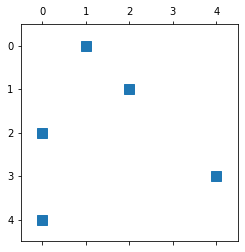

In [52]:
maxiter=300
p1=0.5
p2=0.5
p3=0.01
np.random.seed(10)
W1 = network1(N)
Y1 = dgp(k,N,T,rho0,beta0,gamma0,W1,alpha0,alpha1,X,Err)
print(np.shape(Y1))
plt.spy(W1)
para_W = W1.toarray()
# print(para_W)
para_WW = remove_diag(para_W)
# print(para_WW)
para_true = np.zeros(N*(N-2)+3)
para_true[-3:]=[rho0,gamma0,beta0]
para_true[:-3] = para_WW
tWlist = para_true[0:-3]
print(tWlist)

In [41]:
lower = np.zeros(len(para_true))
lower[-1] = -1
lower[-2] = -1
# print(lower)
upper = np.ones(len(para_true))
tol = 1e-5

In [42]:
from pyswarm import pso

In [43]:
xopt, fopt = pso(gmm_pen_pso,args=(Y1,X,p1,p2,p3),lb=lower,ub=upper,maxiter=1000)

Stopping search: Swarm best position change less than 1e-08


[ 6.71780519e-01  9.67610203e-02  3.28251951e-01  2.81302395e-01
  7.10728585e-01  1.21935094e-01  3.16197512e-06  0.00000000e+00
  7.16705427e-01  1.80265874e-01  6.62276116e-01  2.04488336e-01
  0.00000000e+00  0.00000000e+00  1.34640632e-01  6.22056083e-01
 -7.60175521e-01 -3.84865444e-02]
  (0, 1)	-0.09679348948441313
  (0, 2)	0.6717805186307272
  (0, 3)	0.09676102029099329
  (0, 4)	0.3282519505626927
  (1, 0)	0.2813023948107349
  (1, 2)	-0.11396607395585989
  (1, 3)	0.7107285852520284
  (1, 4)	0.12193509389309648
  (2, 0)	3.161975123655143e-06
  (2, 3)	0.283291410710786
  (2, 4)	0.7167054273140904
  (3, 0)	0.18026587432630778
  (3, 1)	0.6622761161535494
  (3, 2)	0.20448833627575488
  (3, 4)	-0.04703032675561203
  (4, 2)	0.1346406319541919
  (4, 3)	0.865359368045808


Text(0.5, 1.0, 'LASSO')

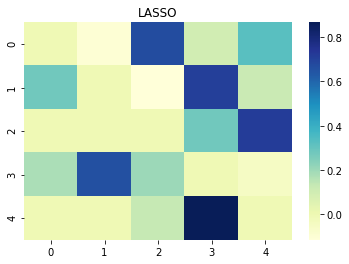

In [44]:
import seaborn as sns
print(xopt)
rWlist_lasso = xopt[0:-3]
rW_lasso = reconstruct(rWlist_lasso)
print(rW_lasso)
ax = sns.heatmap(rW_lasso.A, cmap="YlGnBu")
plt.title('LASSO')

In [53]:
gmm_lasso_paras  = xopt
gmm_lasso_paras[np.abs(gmm_lasso_paras)<tol]=0
rWlist_gmm_lasso= gmm_lasso_paras[0:-3]
# tWlist = para_true[0:-3]
print(rWlist_gmm_lasso)
print(tWlist)
print(np.multiply(rWlist_gmm_lasso,tWlist))
TPR_gmm_lasso = cal_TPR(rWlist_gmm_lasso,tWlist)
TNR_gmm_lasso = cal_TNP(rWlist_gmm_lasso,tWlist)
MSE_gmm_lasso = cal_MSE(gmm_lasso_paras,para_true)
print('TPR is: ', TPR_gmm_lasso)
print('TNR is: ', TNR_gmm_lasso)
print('MSE is: ', MSE_gmm_lasso)

[0.67178052 0.09676102 0.32825195 0.28130239 0.71072859 0.12193509
 0.         0.         0.71670543 0.18026587 0.66227612 0.20448834
 0.         0.         0.13464063]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
TPR is:  0.0
TNR is:  0.15384615384615385
MSE is:  0.33868244620235993
